In [1]:
import os
import sys

os.chdir('/home/thabib/topic_analysis_bert/')
sys.path.append('/home/thabib/topic_analysis_bert/reducers')
sys.path.append('/home/thabib/topic_analysis_bert/models')
sys.path.append('/home/thabib/topic_analysis_bert/utils')
sys.path.append('/home/thabib/topic_analysis_bert/data')
data_root = '/home/thabib/topic_analysis_bert/data/data_'
os.getcwd()

'/home/thabib/topic_analysis_bert'

In [2]:
import numpy as np
import pandas as pd
import h5py
from zipfile import ZipFile
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from reducers.pca import PCAReducer
from clusterers.dbscan import DBSCAN_CLUSTERER
from clusterers.cluster_utils import get_kdist_plot

#### File Args

In [3]:
classes_to_cluster = list(np.arange(10).astype('str')) # ['1','2','4','8','9']
n_samples = 20000

layer = 'pooler_output' # 'pooler_output' # 2048 entries per sample for classification head, 
                        # for 'pooler_output' it is 768

# File name arguments for saving to disk
file_args = {
    'layer': layer,
    'classes': classes_to_cluster,
    'n_samples': n_samples,
}

In [4]:
dataset = pd.read_csv(os.path.join(data_root, 'datasets', 'full_dataset_nan_cleaned.csv'), low_memory=False)

In [5]:
dataset['DDC'] = dataset['DDC'].str[:1]
dataset = dataset.loc[dataset['Title'].str.len() >= 20]
dataset = dataset.rename({'Title': 'text_'}, axis=1)
dataset = dataset.reset_index(drop=True).rename({'Unnamed: 0': 'orig_index'}, axis=1)
dataset = dataset[:1262592] # accounting for total embeddings in the embeddings file (due to batch size of 64)
dataset

,orig_index,ISBN,text_,DDC,Description
0,1,['0226981576'],"Recovered roots, collective memory and the mak...",9,NaN
1,2,['0393965015'],Gravitation and spacetime,5,NaN
2,3,['0715626221'],"The comedy of Menander, convention, variation ...",8,NaN
3,4,['0792331311'],The competitiveness of financial institutions ...,3,NaN
4,5,['0792331893'],International economic law and armed conflict,3,NaN
...,...,...,...,...,...
1262587,1312731,NaN,Die biogenen Amine und ihre Bedeutung für die ...,5,NaN
1262588,1312732,NaN,Die Eiweisskörper und die Theorie der kolloida...,5,NaN
1262589,1312733,NaN,Der Aufbau der hochpolymeren organischen Natur...,5,NaN
1262590,1312734,NaN,Alkylperoxyde und Ozonide : Studien über perox...,5,NaN


In [6]:
sampled_dataset = pd.DataFrame()
for ddc_class in dataset['DDC'].unique():
    sub_frame = dataset.loc[dataset['DDC'] == ddc_class].sample(n=n_samples,replace=False,random_state=42)
    sampled_dataset = pd.concat([sampled_dataset, sub_frame])

#sampled_dataset = sampled_dataset.reset_index(drop=True)
sampled_dataset

,orig_index,ISBN,text_,DDC,Description
1125902,1173175,NaN,De nieuwe arabische mens : Moslims en Christen...,9,NaN
125513,132330,"['3447108010', '9783447108010']","Isis im Römischen Reich, Teil 1: Die Göttin ...",9,NaN
315652,332511,"['0717116247', '0717116255']","Twentieth-century Ireland, nation and state",9,NaN
760429,795760,0813057175978;9780813056401,The historical archaeology of revolutionary wa...,9,Foreword / David R. Starbuck -- Introduction /...
529263,553636,"['3851610296', '9783851610291']",Lykien: ein archäologischer Führer,9,NaN
...,...,...,...,...,...
897758,938699,NaN,The OPL optimization programming language,0,NaN
1073581,1119612,NaN,Vektorquantisierung und kontextabhängige arith...,0,NaN
453579,476264,['3891293917'],Japanbezogene Bibliographien in europäischen S...,0,NaN
200596,212887,"['3540620036', '9783540620037']","The design of intelligent agents, a layered ap...",0,NaN


In [7]:
# Loading a memory map for the extracted .npy file
embeddings = np.load(os.path.join(data_root, 'model_data', 'arr_0.npy'), mmap_mode='c') 
embeddings = embeddings.reshape(embeddings.shape[0]*embeddings.shape[1], embeddings.shape[-1])
    
print(embeddings.shape)

(1262592, 768)


In [8]:
# Sampling the n_samples embeddings for each DDC class
all_ = np.full(len(dataset), False, dtype='bool')
all_[sampled_dataset.index] = True
sampled_embeddings = embeddings[all_]

len(sampled_embeddings), type(sampled_embeddings)

(200000, numpy.ndarray)

## Performing PCA

In [9]:
# OR, load pre-saved PCA embeddings from disk

n_comp = 50
var_retention = 0.85
scaler = RobustScaler

pca_dirname = 'Layer{}_Classes{}_SamplesPerRootClass{}'.format(file_args['layer'],
                                                               ''.join(file_args['classes']),
                                                               file_args['n_samples'])
pca_filename = 'Comp{}_Var{}_Scaler{}'.format(n_comp, int(var_retention * 100), scaler.__name__)

pca_embeddings = np.load(os.path.join(data_root, 'model_data', 'pca_embeddings', pca_dirname, pca_filename+'.npz'), allow_pickle=True)

# Extracting the .npz file into a .npy file
#with ZipFile(os.path.join(data_root, 'model_data', 'pca_embeddings', pca_dirname, pca_filename+'.npz'), 'r') as f:
 #   f.extractall(path=os.path.join(data_root, 'model_data', 'pca_embeddings', pca_dirname), members=['arr_0.npy'])

pca_embeddings = dict(pca_embeddings)

In [10]:
reduced_embeddings = pca_embeddings['reduced_emb']
reduced_embeddings.shape

(200000, 50)

# k-Means

In [8]:
file_args.update({'pca_comp': pca_embeddings_filename.split('_')[0][4:],
                  'pca_var': pca_embeddings_filename.split('_')[1][3:],
                  'pca_scaler': pca_embeddings_filename.split('_')[2][6:]})
        
kmeans_hyperparams = {
    'n_clusters_range': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'init_range': ['k-means++', 'random'],
    'max_iter_range': [500]
    }

kmeans_clusterer = KMEANS_CLUSTERER(n_clusters_range=kmeans_hyperparams['n_clusters_range'],
                                    init_range=kmeans_hyperparams['init_range'],
                                    max_iter_range=kmeans_hyperparams['max_iter_range'])

kmeans_trial_idx, kmeans_trial_results_ = kmeans_clusterer.fit_kmeans(data=reduced_embeddings,
                                                                      true_labels=real_labels,
                                                                      return_result=True,
                                                                      save_to_disk=True,
                                                                      file_args=file_args)

2022-03-24 09:27:51,349 - root : INFO :- Trial=1--Clusters=5, Init=k-means++, Iterations=500
2022-03-24 09:29:27,011 - root : INFO :- Saving to disk...
2022-03-24 09:29:27,019 - root : INFO :- Trial=2--Clusters=6, Init=k-means++, Iterations=500
2022-03-24 09:31:09,805 - root : INFO :- Saving to disk...
2022-03-24 09:31:09,812 - root : INFO :- Trial=3--Clusters=7, Init=k-means++, Iterations=500
2022-03-24 09:33:09,008 - root : INFO :- Saving to disk...
2022-03-24 09:33:09,017 - root : INFO :- Trial=4--Clusters=8, Init=k-means++, Iterations=500
2022-03-24 09:35:17,351 - root : INFO :- Saving to disk...
2022-03-24 09:35:17,360 - root : INFO :- Trial=5--Clusters=9, Init=k-means++, Iterations=500
2022-03-24 09:37:17,738 - root : INFO :- Saving to disk...
2022-03-24 09:37:17,749 - root : INFO :- Trial=6--Clusters=10, Init=k-means++, Iterations=500
2022-03-24 09:39:53,332 - root : INFO :- Saving to disk...
2022-03-24 09:39:53,344 - root : INFO :- Trial=7--Clusters=11, Init=k-means++, Iteratio

In [18]:
kmeans_trial_results_[0]

{'cluster_centers_': array([[ 0.5463497 ,  0.1554157 , -0.53378713, ..., -0.01274005,
         -0.00263152,  0.00550824],
        [-0.3767141 ,  0.7976207 , -0.15985768, ..., -0.01280485,
          0.00280268, -0.01423189],
        [ 0.01445158, -0.14279543, -0.247027  , ..., -0.00885522,
          0.00825046,  0.00368555],
        ...,
        [ 0.31242055,  0.8775864 , -0.26356244, ...,  0.00814256,
         -0.04581908, -0.02733116],
        [-0.04860106, -0.24170715,  0.9046753 , ...,  0.07026729,
         -0.01547822, -0.07471497],
        [ 0.19822985, -1.3309597 , -0.56633687, ...,  0.04156129,
          0.00788102,  0.02566584]], dtype=float32),
 'labels_': array([3, 3, 3, ..., 4, 2, 2], dtype=int32),
 'inertia_': 11775912.0,
 'n_iter_': 155,
 'n_features_in_': 240,
 'silhouette_score': -0.004412948,
 'dunn_index': 0.03773828,
 'dunn_index_corrected': 0.04418276,
 'db_score': 8.622960872806447,
 'adjusted_rand_score': 0.15582380356708483,
 'adjusted_mutual_info_score': 0.423143

In [19]:
kmeans_trial_results_[3]

{'cluster_centers_': array([[ 1.9553764 , -1.0296772 ,  0.91516644, ..., -0.07568528,
         -0.03459656,  0.04957433],
        [-0.0827385 , -0.08351246,  0.04749377, ..., -0.02870934,
          0.01629666,  0.02238744],
        [ 0.1988186 , -1.3805999 , -0.56990075, ...,  0.01172493,
          0.00843214,  0.06069671],
        ...,
        [-0.46262783,  0.85323143,  0.07393291, ..., -0.03752892,
          0.01875783, -0.03687433],
        [ 0.06322808,  0.0139079 ,  0.07134509, ...,  0.04159084,
         -0.06490797, -0.02487661],
        [-0.05840068, -0.24288225,  0.9034989 , ...,  0.06705397,
         -0.01151501, -0.07733459]], dtype=float32),
 'labels_': array([3, 3, 3, ..., 1, 1, 6], dtype=int32),
 'inertia_': 11675252.0,
 'n_iter_': 180,
 'n_features_in_': 240,
 'silhouette_score': -0.0061624427,
 'dunn_index': 0.048596103,
 'dunn_index_corrected': 0.060500663,
 'db_score': 7.992371812626921,
 'adjusted_rand_score': 0.17991332024292153,
 'adjusted_mutual_info_score': 0.457

In [20]:
kmeans_trial_results_[6]

{'cluster_centers_': array([[ 5.20343900e-01,  1.97682455e-01, -5.62165856e-01, ...,
         -1.88831259e-02,  5.93513192e-04,  2.91290749e-02],
        [-3.84367138e-01,  1.93912312e-01, -5.15504360e-01, ...,
          1.11411028e-01, -1.58279147e-02, -2.33200863e-01],
        [ 2.30819702e-01, -1.39514267e+00, -7.03543365e-01, ...,
          4.95886318e-02,  2.81771924e-02,  1.35725319e-01],
        ...,
        [-5.12536883e-01,  8.51880312e-01,  6.68148547e-02, ...,
         -4.93573956e-02,  2.67908163e-02, -1.05425799e-02],
        [ 1.55142680e-01, -3.87503058e-01, -1.28290936e-01, ...,
          5.11931852e-02,  1.02882301e-02, -6.88492432e-02],
        [ 2.02025950e-01,  7.31343508e-01, -1.13687836e-01, ...,
          3.10683046e-02,  3.07172835e-02, -3.64894904e-02]], dtype=float32),
 'labels_': array([ 9,  9,  9, ..., 12,  5,  5], dtype=int32),
 'inertia_': 11584793.0,
 'n_iter_': 75,
 'n_features_in_': 240,
 'silhouette_score': -0.007551219,
 'dunn_index': 0.04529232,
 'du

In [21]:
kmeans_trial_results_[7]

{'cluster_centers_': array([[ 1.42264211e+00, -7.84447610e-01,  5.63435614e-01, ...,
         -1.24677785e-01,  1.38044387e-01,  7.24718049e-02],
        [-6.13577180e-02,  1.35632598e+00,  8.67226541e-01, ...,
         -3.74792423e-03, -3.01708300e-02, -2.25522164e-02],
        [-2.31074259e-01,  6.57047033e-01,  1.00697565e+00, ...,
         -3.23855095e-02, -2.14643348e-02,  4.99337390e-02],
        ...,
        [ 5.27494073e-01,  1.80917904e-01, -5.43121696e-01, ...,
         -1.78086886e-03,  1.00938482e-02,  2.28945557e-02],
        [ 2.04232186e-01, -1.32801378e+00, -5.64214945e-01, ...,
          3.69571149e-02, -1.45271560e-03,  2.87590288e-02],
        [-7.77148381e-02,  2.48409319e-03, -2.63950706e-01, ...,
         -8.57370906e-04,  2.21369043e-03, -5.20810671e-03]], dtype=float32),
 'labels_': array([1, 1, 1, ..., 6, 6, 6], dtype=int32),
 'inertia_': 11776917.0,
 'n_iter_': 131,
 'n_features_in_': 240,
 'silhouette_score': -0.007255914,
 'dunn_index': 0.049305934,
 'dunn_i

In [22]:
kmeans_trial_results_[10]

{'cluster_centers_': array([[ 0.11352461, -1.3345331 , -0.6291049 , ..., -0.02626774,
          0.01627146,  0.04826356],
        [ 0.4804653 ,  0.28236133, -0.55799484, ..., -0.00730806,
          0.01291551,  0.13052143],
        [-0.28121296,  1.0727192 ,  0.66082144, ..., -0.07578716,
          0.10607684,  0.04464425],
        ...,
        [ 1.5030652 , -1.2079142 ,  1.1009365 , ...,  0.13691664,
          0.11363276, -0.10017773],
        [ 0.3919868 , -0.4042612 , -0.21828365, ..., -0.02388675,
         -0.04281881,  0.02288228],
        [-0.45162842,  0.792531  , -0.23594359, ..., -0.01983941,
          0.01583108, -0.00286361]], dtype=float32),
 'labels_': array([6, 6, 6, ..., 3, 3, 8], dtype=int32),
 'inertia_': 11675768.0,
 'n_iter_': 52,
 'n_features_in_': 240,
 'silhouette_score': -0.016778972,
 'dunn_index': 0.043366227,
 'dunn_index_corrected': 0.05201686,
 'db_score': 8.170977084126541,
 'adjusted_rand_score': 0.22146984470802641,
 'adjusted_mutual_info_score': 0.460544

In [12]:
kmeans_trial_results_[21]

{'cluster_centers_': array([[ 2.4949288e-01, -3.7182894e-01, -3.1754789e-01, ...,
          4.9376669e-03, -3.3897549e-02, -4.3092974e-02],
        [ 5.5109829e-01,  2.1464545e-01, -5.6728816e-01, ...,
         -2.1617438e-03,  1.4872249e-02,  3.3501171e-02],
        [-6.6369891e-02, -2.3003550e-01,  9.0217185e-01, ...,
          6.3116871e-02, -1.1857898e-02, -7.7473588e-02],
        ...,
        [ 4.6955886e-01, -9.8243654e-01,  2.3467237e-01, ...,
          2.2425486e-02,  2.2975773e-02, -3.0380173e-02],
        [ 2.2434890e+00, -1.2273248e+00,  1.0739896e+00, ...,
          9.2205435e-02, -3.2149401e-02,  2.2894172e-01],
        [ 1.9171098e-01, -1.3788421e+00, -5.6655353e-01, ...,
          3.8906320e-03, -5.7277293e-04,  5.7648338e-02]], dtype=float32),
 'labels_': array([4, 6, 6, ..., 4, 4, 0], dtype=int32),
 'inertia_': 11521562.0,
 'n_iter_': 100,
 'n_features_in_': 240,
 'silhouette_score': -0.014611303,
 'dunn_index': 0.04598299,
 'dunn_index_corrected': 0.057488333,
 'db_sc

# DBSCAN

#### Finding emperical (optimal) EPS value

In [18]:
# k = 2 * reduced_embeddings.shape[-1] - 1
distances = get_kdist_plot(X=reduced_embeddings, k=99, p=1)

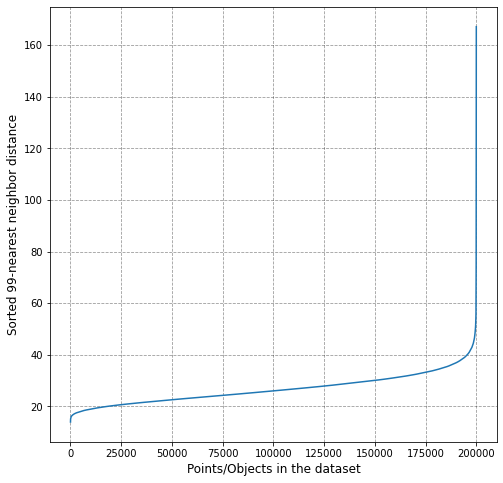

In [20]:
k = 99
plt.figure(figsize=(8,8))
plt.plot(distances[:, k-1])
plt.xlabel('Points/Objects in the dataset', fontsize=12)
plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
plt.grid(True, linestyle="--", color='black', alpha=0.4)
plt.show()
plt.close()

#### When using Manhattan metric

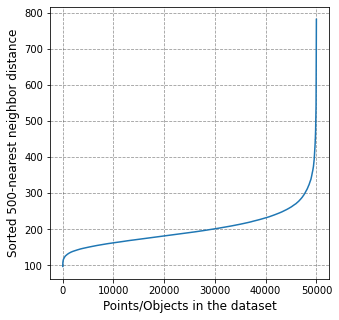

In [21]:
k = 500
plt.figure(figsize=(5,5))
plt.plot(distances[:, k-1])
plt.xlabel('Points/Objects in the dataset', fontsize=12)
plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
plt.grid(True, linestyle="--", color='black', alpha=0.4)
plt.show()
plt.close()

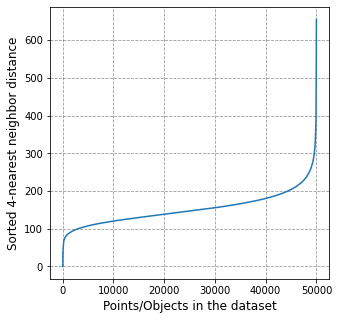

In [23]:
k = 4
plt.figure(figsize=(5,5))
plt.plot(distances[:, k-1])
plt.xlabel('Points/Objects in the dataset', fontsize=12)
plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
plt.grid(True, linestyle="--", color='black', alpha=0.4)
plt.show()
plt.close()

#### When using Euclidean metric

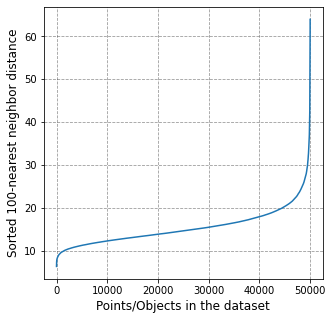

In [12]:
k = 100
plt.figure(figsize=(5,5))
plt.plot(distances[:, k-1])
plt.xlabel('Points/Objects in the dataset', fontsize=12)
plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
plt.grid(True, linestyle="--", color='black', alpha=0.4)
plt.show()
plt.close()

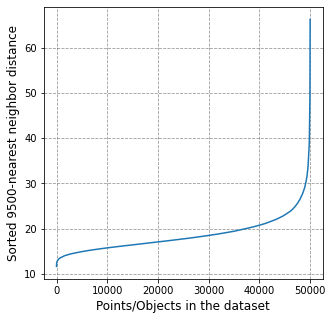

In [15]:
k = 9500
plt.figure(figsize=(5,5))
plt.plot(distances[:, k-1])
plt.xlabel('Points/Objects in the dataset', fontsize=12)
plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
plt.grid(True, linestyle="--", color='black', alpha=0.4)
plt.show()
plt.close()

In [11]:
file_args.update({'pca_comp': 50,
                  'pca_var': 0.85,
                  'pca_scaler': RobustScaler})

k = 2 * reduced_embeddings.shape[-1] - 1  # 'k' is 479 for embeddings of size 240 (layer 7 , classification head)
                                         # 'k' is 159 for embeddings of size 80 (pooler output)
empirical_eps = 50
empirical_min_samples = k + 1

dbscan_hyperparams = {
    'eps_range': [#np.around(empirical_eps - empirical_eps * 0.3, decimals=2),
                  #np.around(empirical_eps - empirical_eps * 0.1, decimals=2),
                  empirical_eps,
                  #np.around(empirical_eps + empirical_eps * 0.1, decimals=2),
                  #np.around(empirical_eps + empirical_eps * 0.3, decimals=2)
    ],
    'min_samples_range': [empirical_min_samples - 50,
                          empirical_min_samples - 25,
                          empirical_min_samples,
                          empirical_min_samples + 25,
                          empirical_min_samples + 50
                         ]
}

real_labels = list(sampled_dataset['DDC'].astype(int))

In [ ]:
dbscan_clusterer = DBSCAN_CLUSTERER(eps_range=dbscan_hyperparams['eps_range'],
                                    min_samples_range=dbscan_hyperparams['min_samples_range'],
                                    metric='minkowski',
                                    p=1)

dbscan_trial_idx, dbscan_trial_results_ = dbscan_clusterer.fit_dbscan(data=reduced_embeddings,
                                                                      true_labels=real_labels,
                                                                      return_result=True,
                                                                      save_to_disk=True,
                                                                      file_args=file_args,
                                                                      use_optics=True)

INFO:root:Trial=1--Eps=50, MinSamples=50


# ROUGH EXPERIMENTS

In [15]:
from sklearn.datasets import make_moons, make_blobs, make_circles
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import DBSCAN, OPTICS


n_samples=5000
noise = 0.1
noises_ = [0.1*noise, noise, 5*noise]
random_ = 0

features_moons, true_labels_moons = make_moons(n_samples=n_samples, noise=noise, random_state=random_)
features_blobs, true_labels_blobs = make_blobs(n_samples=n_samples, centers=3, cluster_std=0.5, random_state=random_)
features_circles, true_labels_circles = make_circles(n_samples=n_samples, noise=noise, factor=0.5, random_state=random_)
features_blobs_, true_labels_blobs_ = make_blobs(n_samples=[3000, 5000, 2000], centers=None, cluster_std=noises_, random_state=random_)

scaler = StandardScaler()
scaled_features_moons = scaler.fit_transform(features_moons)
scaled_features_blobs = scaler.fit_transform(features_blobs)
scaled_features_circles = scaler.fit_transform(features_circles)
scaled_features_blobs_ = scaler.fit_transform(features_blobs_)

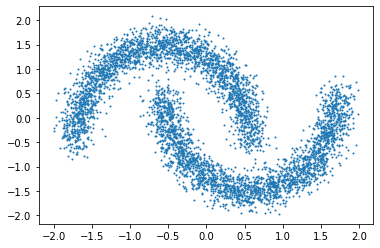

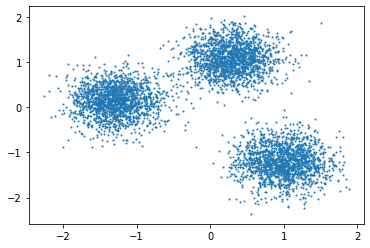

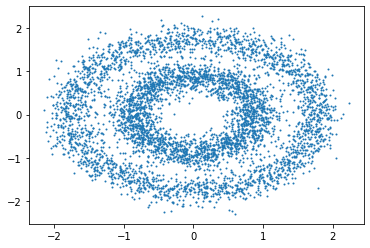

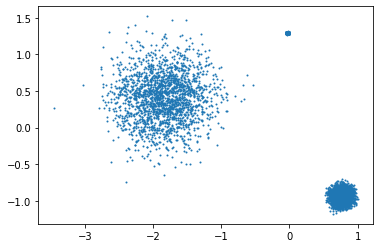

In [16]:
plt.figure()
plt.scatter(scaled_features_moons[:,0], scaled_features_moons[:,1], s=1)
plt.show()

plt.figure()
plt.scatter(scaled_features_blobs[:,0], scaled_features_blobs[:,1], s=1)
plt.show()

plt.figure()
plt.scatter(scaled_features_circles[:,0], scaled_features_circles[:,1], s=1)
plt.show()

plt.figure()
plt.scatter(scaled_features_blobs_[:,0], scaled_features_blobs_[:,1], s=1)
plt.show()


In [422]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
import numpy as np

def get_kdist_plot(X=None, k=None, radius_nbrs=1.0):

    # 'k' is 479 for embeddings of size 240 (layer 7 , classification head)
    # 'k' is 159 for embeddings of size 80 (pooler output)
    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)

    # For each point, compute distances to its k-nearest neighbors
    distances, indices = nbrs.kneighbors(X)  
    distances = np.sort(distances, axis=0)
    k_distances = distances[:, k-1]
    plt.figure(figsize=(8,8))
    plt.plot(k_distances)
    plt.xlabel('Points/Objects in the dataset', fontsize=12)
    plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
    plt.grid(True, linestyle="--", color='black', alpha=0.4)
    plt.show()
    
    return distances

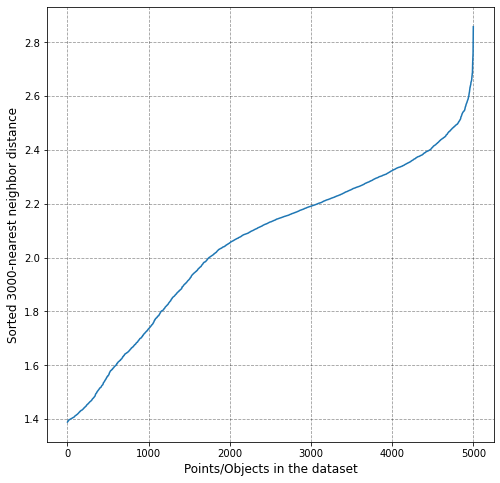

In [617]:
distances_moons = get_kdist_plot(X=scaled_features_moons, k=3000)

# When k=5000, the first point of inflection occurs at around 1.5

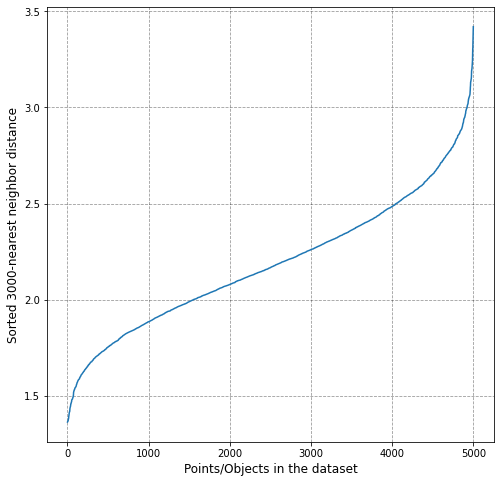

In [618]:
distances_blobs = get_kdist_plot(X=scaled_features_blobs, k=3000)

# When k=3333, the first point of inflection occurs around 1.25

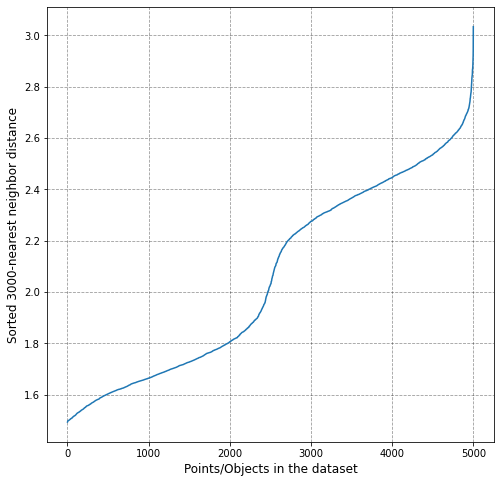

In [619]:
distances_circles = get_kdist_plot(X=scaled_features_circles, k=3000)

# When k=5000, the first point of inflection occurs at around 1.5

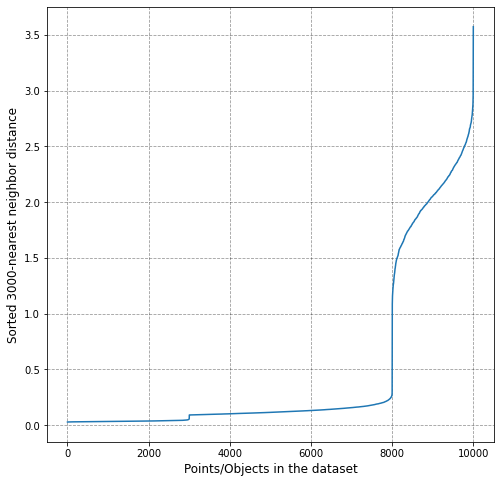

In [635]:
distances_blobs_ = get_kdist_plot(X=scaled_features_blobs_, k=3000)

# When k=5000, the first point of inflection occurs at around 1.5

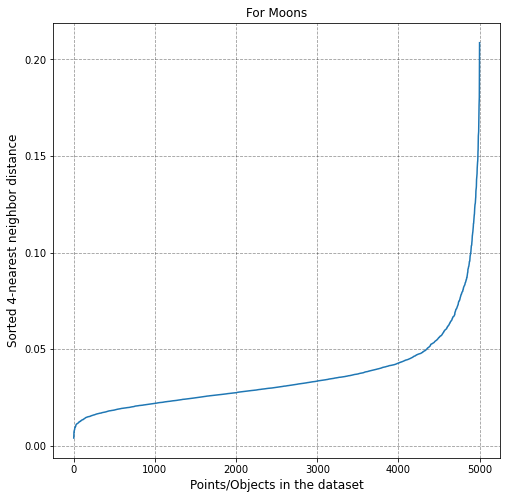

In [622]:
k = 4
plt.figure(figsize=(8,8))
plt.plot(distances_moons[:,k-1])
plt.xlabel('Points/Objects in the dataset', fontsize=12)
plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
plt.title('For Moons')
plt.grid(True, linestyle="--", color='black', alpha=0.4)
plt.show()

#distances_moons[:,k-1][9990]


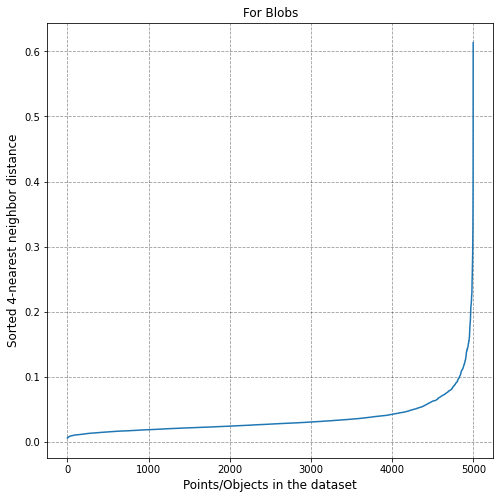

In [623]:
k = 4
plt.figure(figsize=(8,8))
plt.plot(distances_blobs[:,k-1])
plt.xlabel('Points/Objects in the dataset', fontsize=12)
plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
plt.title('For Blobs')
plt.grid(True, linestyle="--", color='black', alpha=0.4)
plt.show()

#distances_blobs[:,k-1][9990]

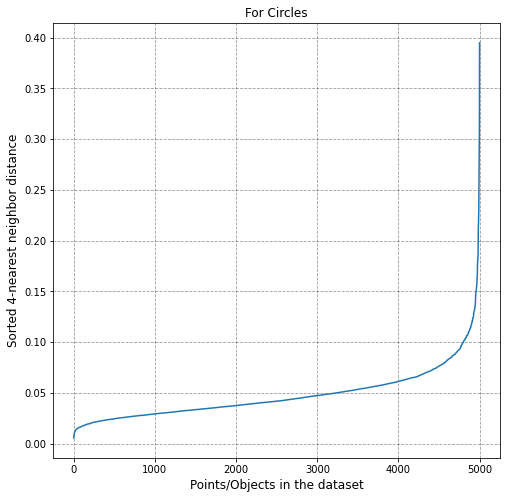

In [624]:
k = 4
plt.figure(figsize=(8,8))
plt.plot(distances_circles[:,k-1])
plt.xlabel('Points/Objects in the dataset', fontsize=12)
plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
plt.title('For Circles')
plt.grid(True, linestyle="--", color='black', alpha=0.4)
plt.show()

#distances_blobs[:,k-1][9990]

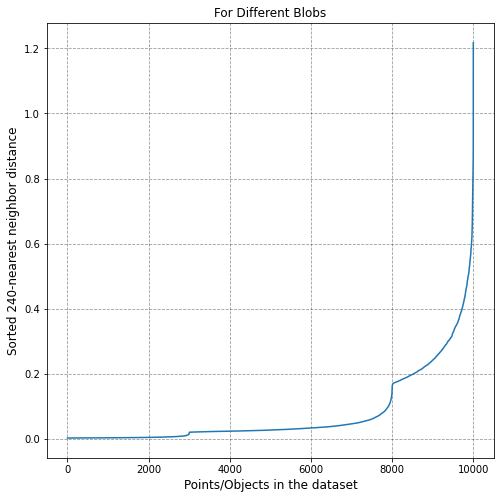

In [646]:
k = 240
plt.figure(figsize=(8,8))
plt.plot(distances_blobs_[:,k-1])
plt.xlabel('Points/Objects in the dataset', fontsize=12)
plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
plt.title('For Different Blobs')
plt.grid(True, linestyle="--", color='black', alpha=0.4)
plt.show()

#distances_blobs[:,k-1][4900]

In [18]:
from sklearn.metrics import silhouette_score

dbscan_moons = DBSCAN(eps=0.175, min_samples=70) # 0.175, 70
dbscan_moons.fit(scaled_features_moons)
dbscan_blobs = DBSCAN(eps=0.275, min_samples=120) # 0.275, 120
dbscan_blobs.fit(scaled_features_blobs)
dbscan_circles = DBSCAN(eps=0.250, min_samples=60) # 0.250, 60
dbscan_circles.fit(scaled_features_circles)
dbscan_blobs_ = DBSCAN(eps=0.2, min_samples=220) # 0.250, 260
dbscan_blobs_.fit(scaled_features_blobs_)

optics_moons = OPTICS(min_samples=70, eps=0.175, cluster_method='dbscan')
optics_moons.fit(scaled_features_moons)
optics_blobs = OPTICS(min_samples=120, eps=0.275, cluster_method='dbscan')
optics_blobs.fit(scaled_features_blobs)
optics_circles = OPTICS(min_samples=60, eps=0.250, cluster_method='dbscan')
optics_circles.fit(scaled_features_circles)
optics_blobs_ = OPTICS(min_samples=220, eps=0.2, cluster_method='dbscan')
optics_blobs_.fit(scaled_features_blobs_)


print('Labels:')
print(np.unique(dbscan_moons.labels_))
print(np.unique(dbscan_blobs.labels_))
print(np.unique(dbscan_circles.labels_))
print(np.unique(dbscan_blobs_.labels_))
print('Nof Noise points:')
print(len(np.where(dbscan_moons.labels_==-1)[0]))
print(len(np.where(dbscan_blobs.labels_==-1)[0]))
print(len(np.where(dbscan_circles.labels_==-1)[0]))
print(len(np.where(dbscan_blobs_.labels_==-1)[0]))
# print('Silhouette Scores:')
# print(silhouette_score(scaled_features_moons, dbscan_moons.labels_))
# print(silhouette_score(scaled_features_blobs, dbscan_blobs.labels_))
# print(silhouette_score(scaled_features_circles, dbscan_circles.labels_))
# print(silhouette_score(scaled_features_blobs_, dbscan_blobs_.labels_))

print('\nResults for OPTICS:')
print('Labels:')
print(np.unique(optics_moons.labels_))
print(np.unique(optics_blobs.labels_))
print(np.unique(optics_circles.labels_))
print(np.unique(optics_blobs_.labels_))
print('Nof Noise points:')
print(len(np.where(optics_moons.labels_==-1)[0]))
print(len(np.where(optics_blobs.labels_==-1)[0]))
print(len(np.where(optics_circles.labels_==-1)[0]))
print(len(np.where(optics_blobs_.labels_==-1)[0]))
# print(silhouette_score(scaled_features_moons, optics_moons.labels_))
# print(silhouette_score(scaled_features_blobs, optics_blobs.labels_))
# print(np.unique(dbscan_moons.labels_))
# print(np.unique(dbscan_blobs.labels_))

Labels:
[-1  0  1]
[-1  0  1  2]
[-1  0  1]
[-1  0  1  2]
Nof Noise points:
242
146
44
700

Results for OPTICS:
Labels:
[-1  0  1]
[-1  0  1  2]
[-1  0  1]
[-1  0  1  2]
Nof Noise points:
243
153
75
701


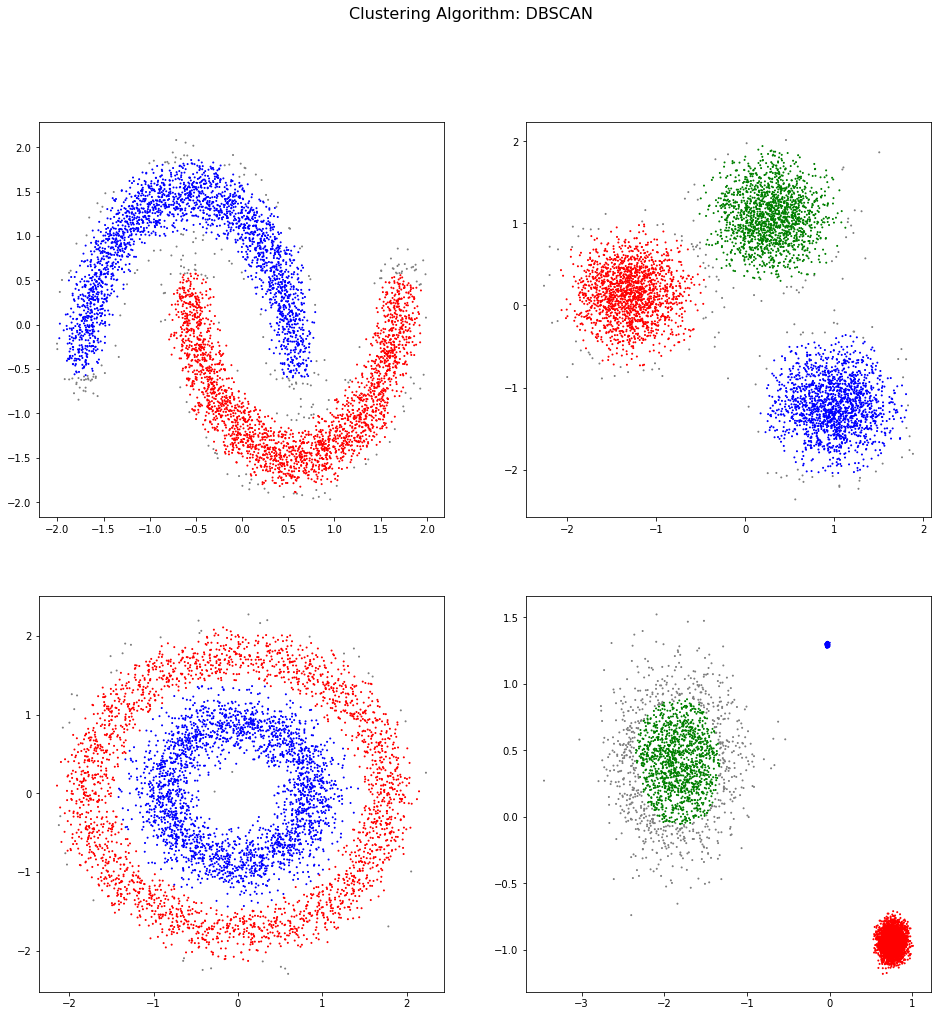

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
fig.suptitle(f"Clustering Algorithm: DBSCAN", fontsize=16)
fte_colors = {0: 'blue', 1: 'red', -1: 'grey', 2: 'green'}

# plot for moons
km_colors = [fte_colors[label] for label in dbscan_moons.labels_]
axes[0][0].scatter(scaled_features_moons[:, 0], scaled_features_moons[:, 1], c=km_colors, s=1)
#ax1.set_title(f"k-means\nSilhouette: {kmeans_silhouette}", fontdict={"fontsize": 12})

# plot for blobs
db_colors = [fte_colors[label] for label in dbscan_blobs.labels_]
axes[0][1].scatter(scaled_features_blobs[:, 0], scaled_features_blobs[:, 1], c=db_colors, s=1)
#ax2.set_title(f"DBSCAN\nSilhouette: {dbscan_silhouette}", fontdict={"fontsize": 12})

# plot for circles
db_colors = [fte_colors[label] for label in dbscan_circles.labels_]
axes[1][0].scatter(scaled_features_circles[:, 0], scaled_features_circles[:, 1], c=db_colors, s=1)
#ax2.set_title(f"DBSCAN\nSilhouette: {dbscan_silhouette}", fontdict={"fontsize": 12})

# plot for blobs_
db_colors = [fte_colors[label] for label in dbscan_blobs_.labels_]
axes[1][1].scatter(scaled_features_blobs_[:, 0], scaled_features_blobs_[:, 1], c=db_colors, s=1)
#ax2.set_title(f"DBSCAN\nSilhouette: {dbscan_silhouette}", fontdict={"fontsize": 12})
plt.show()

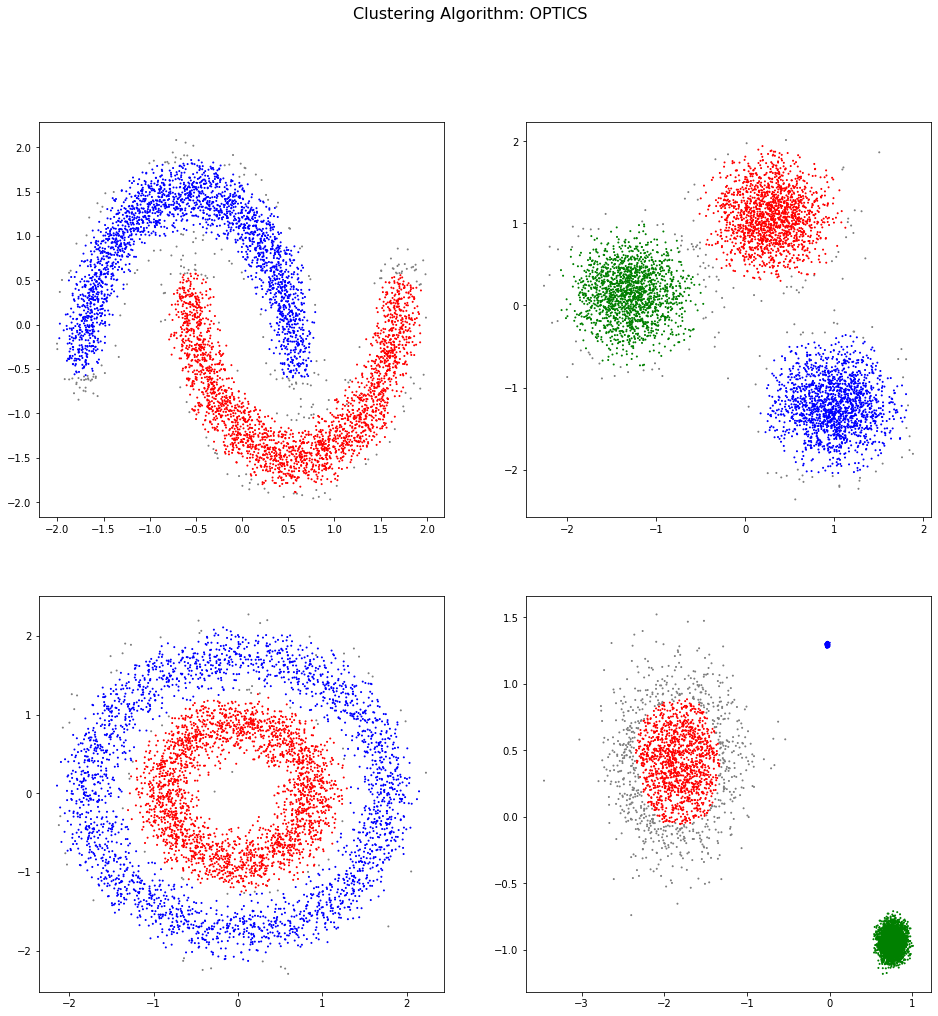

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
fig.suptitle(f"Clustering Algorithm: OPTICS", fontsize=16)
fte_colors = {0: 'blue', 1: 'red', -1: 'grey', 2: 'green'}

# plot for moons
km_colors = [fte_colors[label] for label in optics_moons.labels_]
axes[0][0].scatter(scaled_features_moons[:, 0], scaled_features_moons[:, 1], c=km_colors, s=1)
#ax1.set_title(f"k-means\nSilhouette: {kmeans_silhouette}", fontdict={"fontsize": 12})

# plot for blobs
db_colors = [fte_colors[label] for label in optics_blobs.labels_]
axes[0][1].scatter(scaled_features_blobs[:, 0], scaled_features_blobs[:, 1], c=db_colors, s=1)
#ax2.set_title(f"DBSCAN\nSilhouette: {dbscan_silhouette}", fontdict={"fontsize": 12})

# plot for circles
db_colors = [fte_colors[label] for label in optics_circles.labels_]
axes[1][0].scatter(scaled_features_circles[:, 0], scaled_features_circles[:, 1], c=db_colors, s=1)
#ax2.set_title(f"DBSCAN\nSilhouette: {dbscan_silhouette}", fontdict={"fontsize": 12})

# plot for blobs_
db_colors = [fte_colors[label] for label in optics_blobs_.labels_]
axes[1][1].scatter(scaled_features_blobs_[:, 0], scaled_features_blobs_[:, 1], c=db_colors, s=1)
#ax2.set_title(f"DBSCAN\nSilhouette: {dbscan_silhouette}", fontdict={"fontsize": 12})
plt.show()